# Snowflake API Tutorial: Bitcoin Price Analysis

This tutorial demonstrates how to connect to Snowflake, ingest Bitcoin price data from S3, and perform time-series analysis. We simulate a modern cloud-based data pipeline using Snowpipe and Python.

## Setting Up

We begin by installing required libraries and loading environment variables from a `.env` file.

In [57]:
import os
import pandas as pd
import snowflake.connector
import matplotlib.pyplot as plt
from prophet import Prophet
from dotenv import load_dotenv

load_dotenv()

True

## Connecting to Snowflake

We establish a secure connection to Snowflake using Python and credentials stored in `.env`.

In [60]:
conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA")
)

## Retrieving Bitcoin Price Data

We run a simple SQL query to fetch all historical Bitcoin prices from our Snowflake table `bitcoin_prices`.

In [63]:
query = "SELECT * FROM bitcoin_prices ORDER BY timestamp"
df = pd.read_sql(query, conn)
conn.close()

/var/folders/6m/dzrd9s2d325c1kzl4p0vn7rh0000gn/T/ipykernel_6152/1008224124.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Parsing Timestamp for Time-Series Analysis

Convert `timestamp` column to `datetime` format and set it as the index.

In [66]:
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,price
timestamp,
2025-01-18,104160.693585
2025-01-18,104160.693585
2025-01-19,104334.615757
2025-01-19,104334.615757
2025-01-20,101275.337148


## Visualizing Bitcoin Price Over Time

We now create a line chart of BTC price data to observe trends.

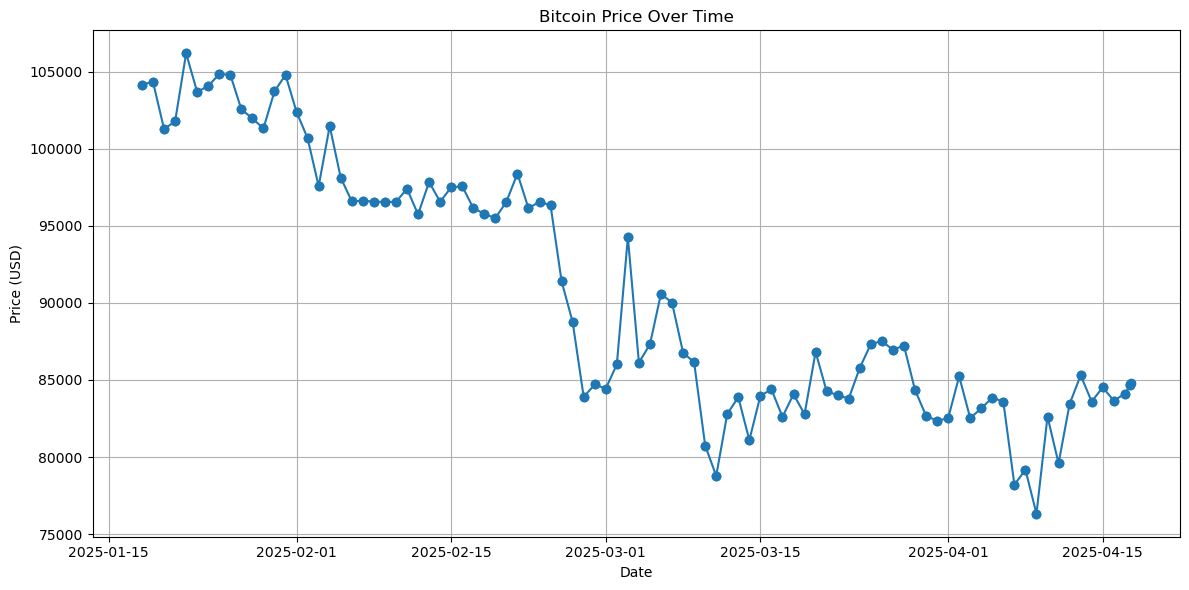

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], marker='o', linestyle='-')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.tight_layout()
plt.show()

## Adding a Moving Average

We compute a 7-day moving average to visualize price trends.

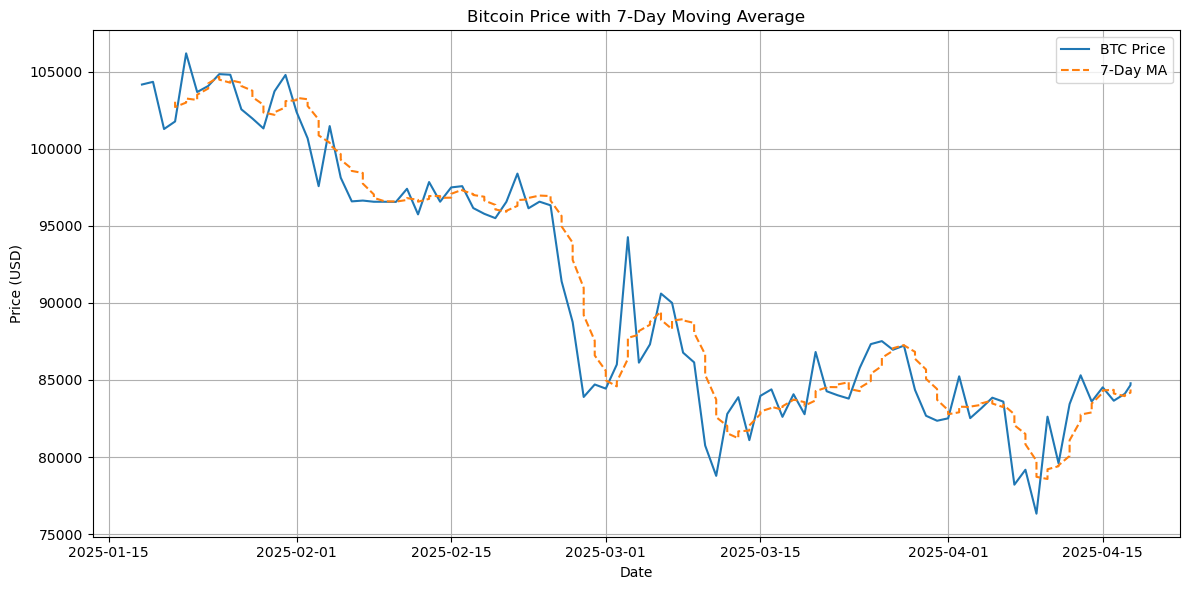

In [72]:
df['ma_7'] = df['price'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['price'], label='BTC Price')
plt.plot(df['ma_7'], label='7-Day MA', linestyle='--')
plt.title('Bitcoin Price with 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Adding a Moving Average

We compute a 15-day moving average to visualize price trends.

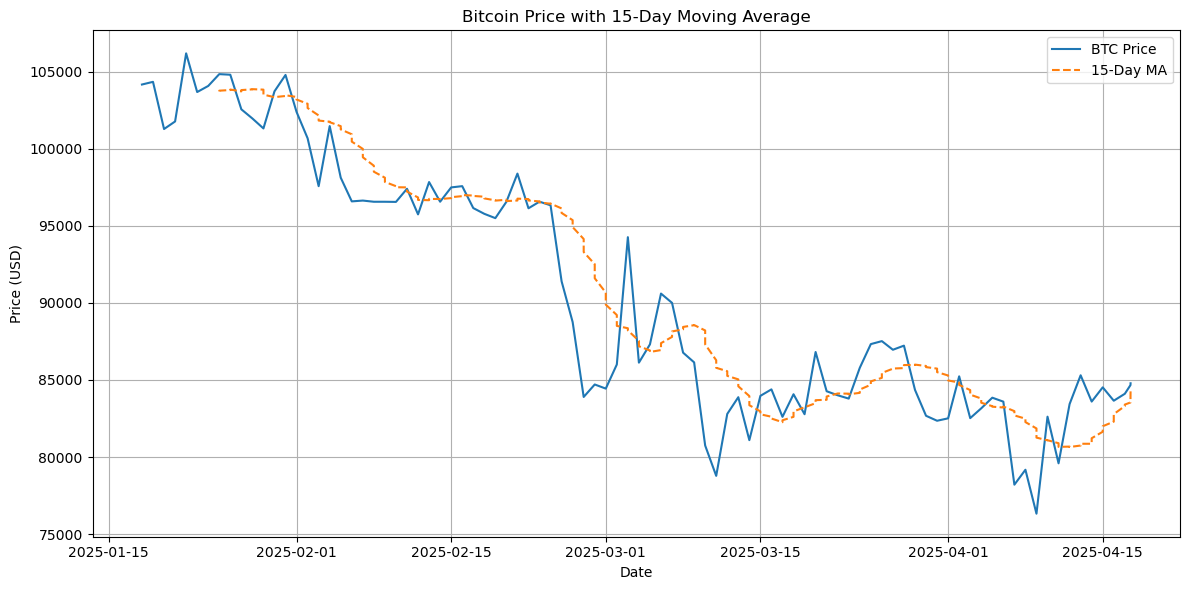

In [75]:
df['ma_15'] = df['price'].rolling(window=15).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['price'], label='BTC Price')
plt.plot(df['ma_15'], label='15-Day MA', linestyle='--')
plt.title('Bitcoin Price with 15-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Daily Returns

Measure % change between consecutive days — useful to evaluate volatility.

<Axes: title={'center': 'Daily % Change in BTC Price'}, xlabel='timestamp'>

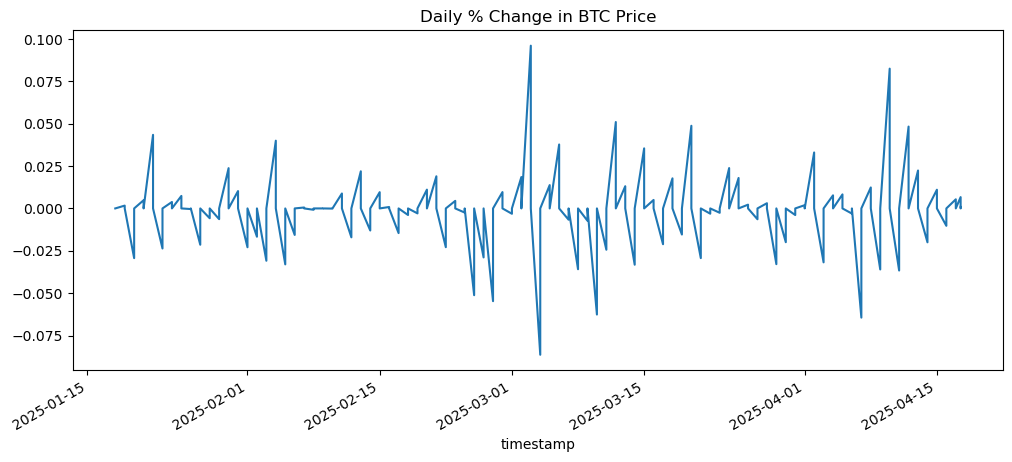

In [24]:
df['daily_return'] = df['price'].pct_change()
df['daily_return'].plot(title="Daily % Change in BTC Price", figsize=(12, 5))

## Rolling Statistics

Compute rolling std deviation, min, max over 7, 14, or 30 days.

<Axes: title={'center': 'BTC Price & 14-Day Rolling Std Dev'}, xlabel='timestamp'>

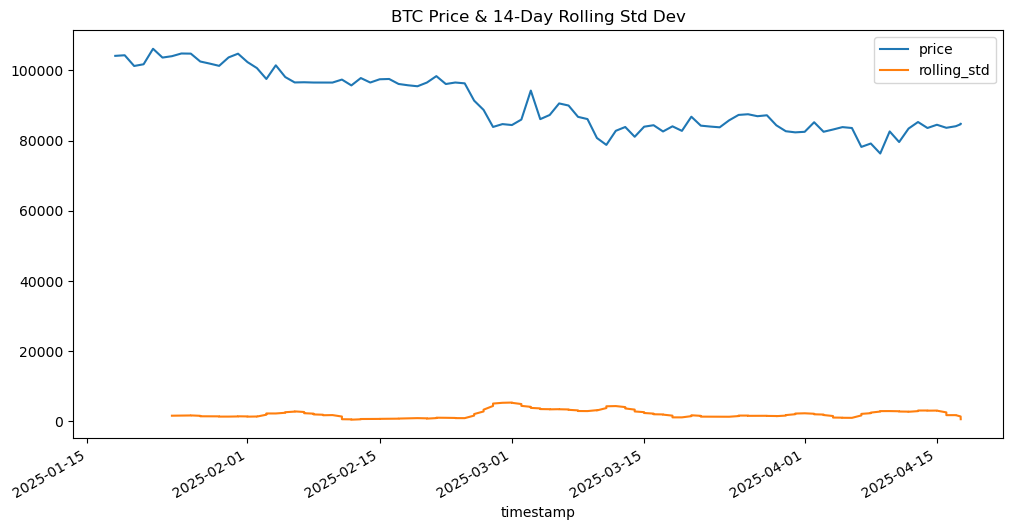

In [28]:
df['rolling_std'] = df['price'].rolling(14).std()
df[['price', 'rolling_std']].plot(figsize=(12,6), title='BTC Price & 14-Day Rolling Std Dev')

## Exponential Moving Average (EMA)

Gives more weight to recent prices.

In [32]:
df['ema_14'] = df['price'].ewm(span=14, adjust=False).mean()

## Bollinger Bands

Upper/lower bands based on moving average ± standard deviation.

In [36]:
ma = df['price'].rolling(window=20).mean()
std = df['price'].rolling(window=20).std()
df['upper_band'] = ma + (2 * std)
df['lower_band'] = ma - (2 * std)

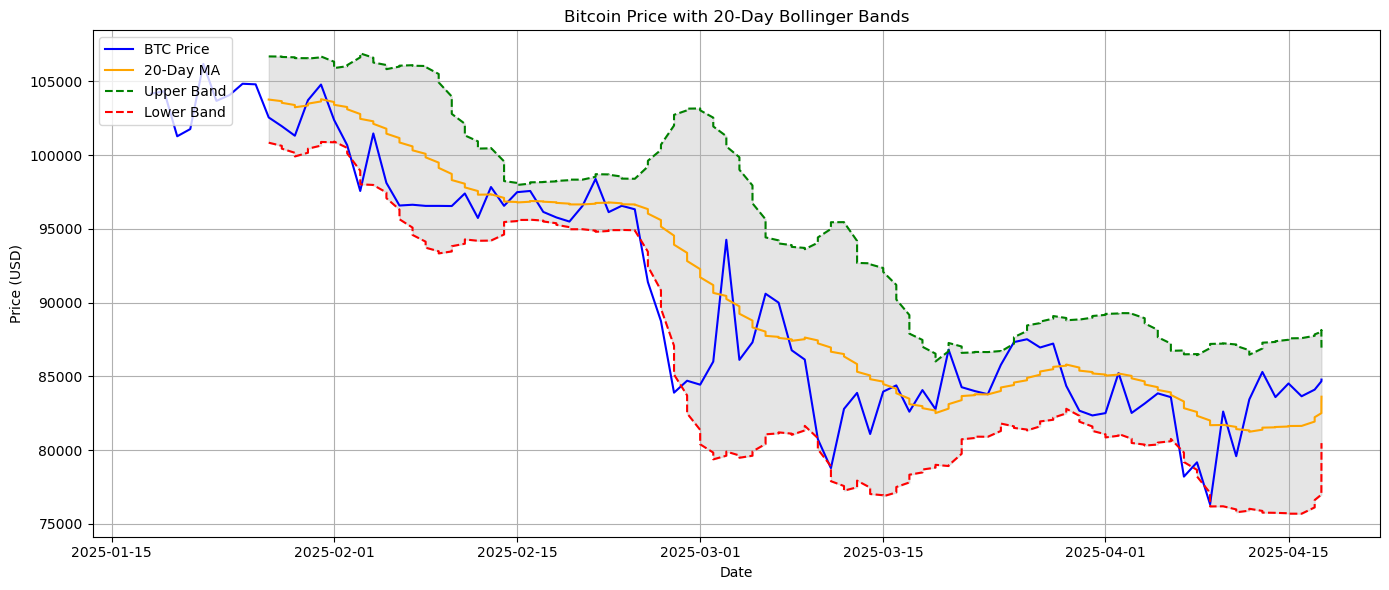

In [38]:
# Calculate moving average and standard deviation
window = 20
ma = df['price'].rolling(window=window).mean()
std = df['price'].rolling(window=window).std()
# Calculate upper and lower bands
df['upper_band'] = ma + (2 * std)
df['lower_band'] = ma - (2 * std)
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df['price'], label='BTC Price', color='blue')
plt.plot(ma, label=f'{window}-Day MA', color='orange')
plt.plot(df['upper_band'], label='Upper Band', linestyle='--', color='green')
plt.plot(df['lower_band'], label='Lower Band', linestyle='--', color='red')
# Fill between upper and lower bands
plt.fill_between(df.index, df['lower_band'], df['upper_band'], color='gray', alpha=0.2)
plt.title(f'Bitcoin Price with {window}-Day Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Detect Spikes or Dips

Find dates where returns or std dev exceed thresholds.

In [42]:
anomalies = df[df['daily_return'].abs() > 0.05]

In [44]:
anomalies

,price,ma_7,ma_15,daily_return,rolling_std,ema_14,upper_band,lower_band
timestamp,,,,,,,,
2025-02-25,91396.766869,95635.758881,96124.852506,-0.051187,1624.508522,95902.613253,99225.501039,93454.485899
2025-02-27,83900.114965,90980.016223,94142.474037,-0.054708,4373.225647,92369.594230,102006.613875,87076.441780
2025-03-03,94261.532865,86367.733923,88355.624399,0.095997,4120.191067,88617.668084,101284.032760,79627.697488
2025-03-04,86124.714187,87934.584994,87537.712457,-0.086322,3674.681939,88937.454161,99854.685900,79643.721774
2025-03-10,80751.138933,86655.225622,88212.589737,-0.062592,3168.861532,86984.974160,94060.957351,80818.273236
2025-03-12,82799.108029,82022.176253,85568.965338,0.050964,4319.394412,84116.799245,95457.537022,77573.686025
2025-04-07,78211.483582,82776.463577,82980.280939,-0.064410,1675.287077,82950.616519,86760.747187,79840.129721
2025-04-10,82622.170295,78580.271815,81089.233898,0.082447,2907.365929,80558.558600,87225.022785,76194.802426


# Prophet Forecasting

Quick and interpretable forecasting by Meta

In [48]:
df_prophet = df.reset_index()[['timestamp', 'price']].rename(columns={'timestamp': 'ds', 'price': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

23:00:12 - cmdstanpy - INFO - Chain [1] start processing
23:00:12 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-01-18 00:00:00,104793.797892,102251.404069,108848.397807,104793.797892,104793.797892,794.771576,794.771576,794.771576,602.803991,602.803991,602.803991,191.967585,191.967585,191.967585,0.0,0.0,0.0,105588.569468
1,2025-01-19 00:00:00,104460.562268,102412.351131,108789.418342,104460.562268,104460.562268,1052.748818,1052.748818,1052.748818,602.803991,602.803991,602.803991,449.944827,449.944827,449.944827,0.0,0.0,0.0,105513.311086
2,2025-01-20 00:00:00,104127.326644,101154.021988,107774.327733,104127.326644,104127.326644,205.915862,205.915862,205.915862,602.803991,602.803991,602.803991,-396.888130,-396.888130,-396.888130,0.0,0.0,0.0,104333.242505
3,2025-01-21 00:00:00,103794.091020,100573.472425,107092.751622,103794.091020,103794.091020,28.253908,28.253908,28.253908,602.803991,602.803991,602.803991,-574.550083,-574.550083,-574.550083,0.0,0.0,0.0,103822.344928
4,2025-01-22 00:00:00,103460.855369,100473.915331,107011.201062,103460.855369,103460.855369,193.121008,193.121008,193.121008,602.803991,602.803991,602.803991,-409.682983,-409.682983,-409.682983,0.0,0.0,0.0,103653.976377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2025-05-13 12:30:13,80411.608122,78630.272788,85997.899662,78550.558994,82220.272587,1839.960724,1839.960724,1839.960724,2411.445599,2411.445599,2411.445599,-571.484875,-571.484875,-571.484875,0.0,0.0,0.0,82251.568846
120,2025-05-14 12:30:13,80357.387905,78884.526280,86774.329382,78391.502558,82264.033277,2471.307873,2471.307873,2471.307873,2411.445599,2411.445599,2411.445599,59.862274,59.862274,59.862274,0.0,0.0,0.0,82828.695778
121,2025-05-15 12:30:13,80303.167688,79269.486149,87025.699693,78234.723137,82343.794409,2964.693950,2964.693950,2964.693950,2411.445599,2411.445599,2411.445599,553.248350,553.248350,553.248350,0.0,0.0,0.0,83267.861637
122,2025-05-16 12:30:13,80248.947471,78789.428870,86460.025962,78061.161865,82421.232808,2424.586245,2424.586245,2424.586245,2411.445599,2411.445599,2411.445599,13.140646,13.140646,13.140646,0.0,0.0,0.0,82673.533715


# Histogram of Daily Returns

Compare average return to its volatility.

In [54]:
sharpe_ratio = df['daily_return'].mean() / df['daily_return'].std()
sharpe_ratio

-0.04575985739424738